In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  import test and train modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# read data
df_sf = pd.read_csv('sf_data.csv', sep=';')
df_district = pd.read_csv('sf_districts.csv', sep=';')

In [3]:
def load_data():
    # import data from csv separated by semicolon
    df = pd.read_csv('sf_data.csv', sep=';')

    df_district = pd.read_csv('sf_districts.csv', sep=';')

    # merge dataframes on id
    df = pd.merge(df, df_district, on='id') # this is a left join that drops na values

    # check for missing values
    print(f'this is how many na values are in the dataframe: {df.isna().sum()}')

    return df



In [81]:
df = load_data()

this is how many na values are in the dataframe: id             0
category       0
description    0
weekday        0
date           0
time           0
resolution     0
longitude      0
latitude       0
label          0
district       0
dtype: int64


In [82]:
def format_data(df):
    # convert all object columns to category
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category')

    # make weekday column a datetime object where monday is 0 and sunday is 6
    df['weekday'] = pd.to_datetime(df['date']).dt.dayofweek

    # make date column a datetime object
    df['date'] = pd.to_datetime(df['date']).dt.date

    # make time column a datetime object
    df['time'] = pd.to_datetime(df['time']).dt.time

    # make a new column that is date and time combined
    df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

    # set datetime as index
    df.set_index('datetime')

    return df

# use function to clean data
df = format_data(df)

/var/folders/_c/3l9yllq94xz0c2hc259xh3jc0000gn/T/ipykernel_56902/1119003012.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=90)


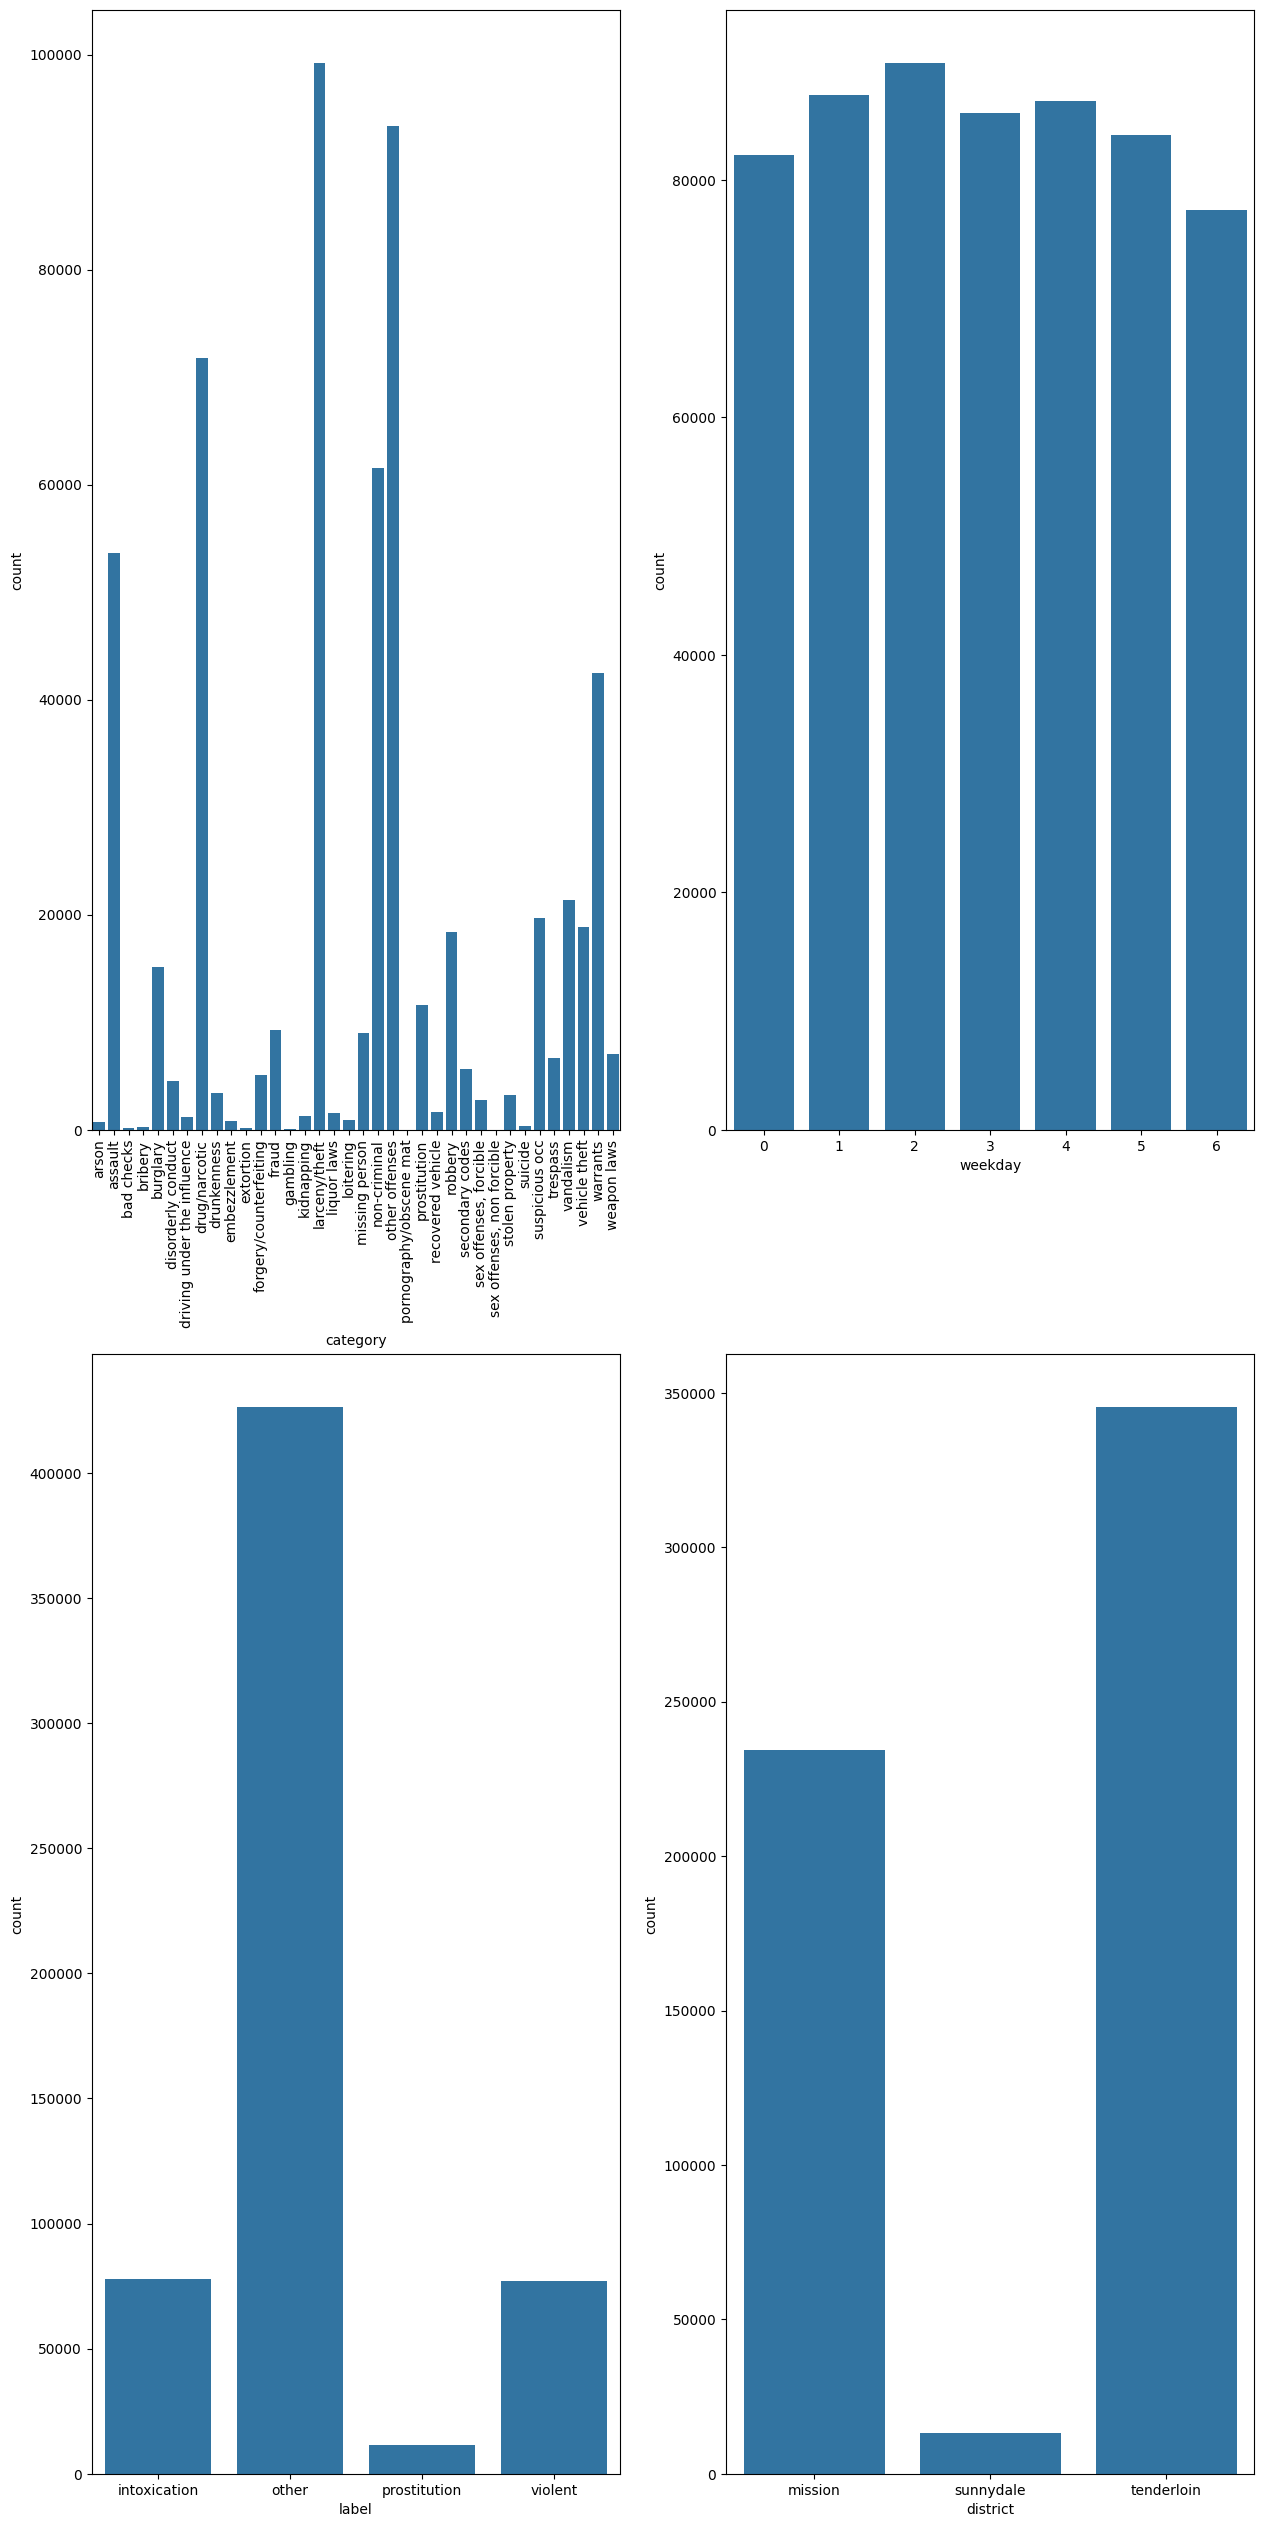

In [83]:
# visualize using bar plots
# put all plots into one plot
fig, ax = plt.subplots(2, 2, figsize=(15, 32))

# plot all the data
# rotate x labels
sns.countplot(x='category', data=df, ax=ax[0, 0])
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=90)
sns.countplot(x='weekday', data=df, ax=ax[0, 1])
sns.countplot(x='label', data=df, ax=ax[1, 0])
sns.countplot(x='district', data=df, ax=ax[1, 1])

plt.show()


<Axes: title={'center': 'Number of crimes per day per district'}, xlabel='date'>

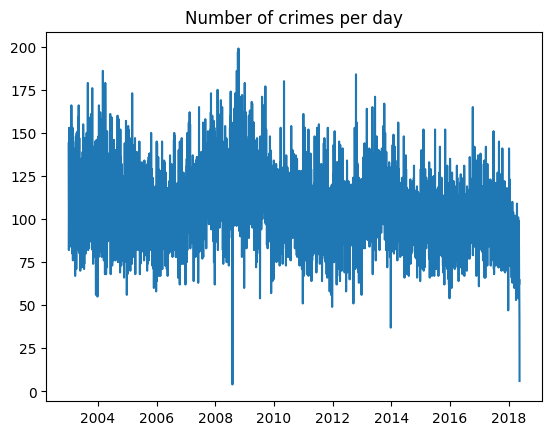

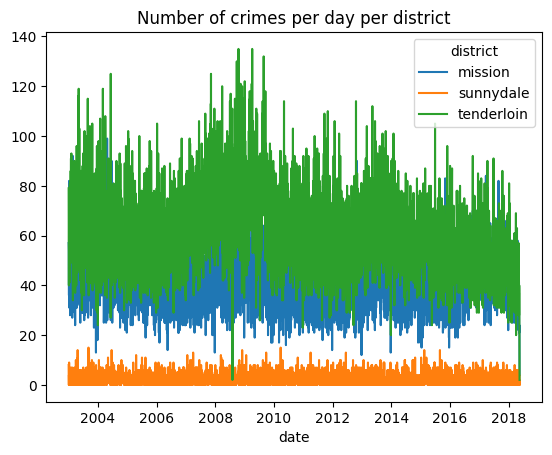

In [84]:
# visualize datetime

# plot the number of crimes + title
df['date'].value_counts().plot(title='Number of crimes per day')


# plot number of crimes per day per district
df.groupby(['date', 'district']).size().unstack().plot(title='Number of crimes per day per district')



In [85]:
# create time features
def create_time_features(df):
    # create time features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['weekday'] = df['datetime'].dt.weekday

    return df

# use function to create time features
df = create_time_features(df)

In [86]:
# make a numerical column with number of crimes per day
df['num_crimes'] = df['date'].map(df['date'].value_counts())

# make a numerical column with number of crimes per hour of the particular day
df['num_crimes_hour'] = df['datetime'].map(df['datetime'].value_counts())




In [101]:
# make a dataframe with only the features and the target
dfXGB = df[['year', 'month', 'day', 'hour', 'minute', 'weekday', 'num_crimes', 'datetime', 'num_crimes_hour']]

# set datetime as index
dfXGB.set_index('datetime')

,year,month,day,hour,minute,weekday,num_crimes,num_crimes_hour
datetime,,,,,,,,
2018-03-24 07:00:00,2018,3,24,7,0,5,83,3
2017-07-19 12:00:00,2017,7,19,12,0,2,95,4
2017-10-13 06:45:00,2017,10,13,6,45,4,141,2
2018-04-22 18:00:00,2018,4,22,18,0,6,72,1
2016-08-21 10:00:00,2016,8,21,10,0,6,104,1
...,...,...,...,...,...,...,...,...
2017-04-26 18:00:00,2017,4,26,18,0,2,108,2
2016-12-28 22:34:00,2016,12,28,22,34,2,93,1
2017-07-08 03:30:00,2017,7,8,3,30,5,104,3


In [103]:
# write dfXGB to csv and save in the Data folder
dfXGB.to_csv('/Users/kristian/Documents/CasePFA/Models/Data/dfNumeric.csv')

In [88]:
# find train and test manually


# find train and test by finding the 80th percentile
# split the data
train = dfXGB[dfXGB['datetime'] < dfXGB['datetime'].quantile(0.8)]
test = dfXGB[dfXGB['datetime'] >= dfXGB['datetime'].quantile(0.8)]

# define split date
split_date = '2015-01-05'

In [89]:
print(f'this is the shape of the train data: {train.shape}')    
print(f'this is the shape of the test data: {test.shape}')

# print min and max date range
print(f'this is the min date in the train data: {train["datetime"].min()}')
print(f'this is the max date in the train data: {train["datetime"].max()}')
print(f'this is the min date in the test data: {test["datetime"].min()}')
print(f'this is the max date in the test data: {test["datetime"].max()}')

this is the shape of the train data: (474282, 9)
this is the shape of the test data: (118572, 9)
this is the min date in the train data: 2003-01-01 00:01:00
this is the max date in the train data: 2015-01-05 06:55:00
this is the min date in the test data: 2015-01-05 08:00:00
this is the max date in the test data: 2018-05-15 02:01:00


In [90]:
# make a df without num_crimes
df_no_num_crimes = dfXGB.drop('num_crimes', axis=1)
df_no_num_crimes = df_no_num_crimes.set_index('datetime')

In [92]:
# make datetime index
train = train.set_index('datetime') # works only if not already set
test = test.set_index('datetime')  # works only if not already set

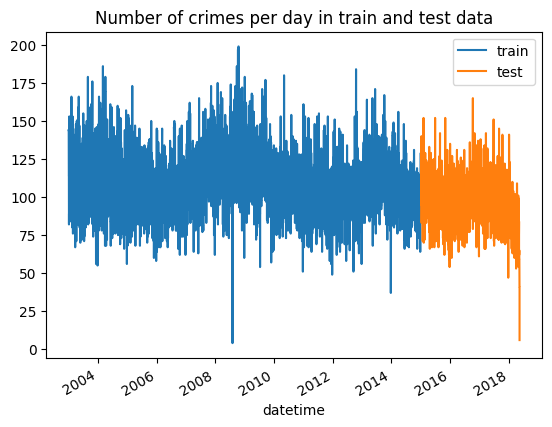

In [93]:
# plot train and test with number of crimes per day so time on the x axis as dates
train['num_crimes'].plot(title='Number of crimes per day in train and test data')
test['num_crimes'].plot()

# legend
plt.legend(['train', 'test'])





In [94]:
# must be done for visualizing the data
dfXGB = dfXGB.set_index('datetime')

/var/folders/_c/3l9yllq94xz0c2hc259xh3jc0000gn/T/ipykernel_56902/3678576221.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dfXGB['2014-01-01':'2014-01-07'].groupby('hour')['num_crimes_hour'].mean().plot(ax = ax, title = 'Number of mean crimes per hour of the day for a random week')
/var/folders/_c/3l9yllq94xz0c2hc259xh3jc0000gn/T/ipykernel_56902/3678576221.py:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dfXGB['2014-01-08':'2014-01-14'].groupby('hour')['num_crimes_hour'].mean().plot(ax = ax, title = 'Number of mean crimes per hour of the day for a random week')
/var/folders/_c/3l9yllq94xz0c2hc259xh3jc0000gn/T/ipykernel_56902/3678576221.py:12: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is depreca

<Axes: title={'center': 'Number of mean crimes per hour of the day for a random week'}, xlabel='hour'>

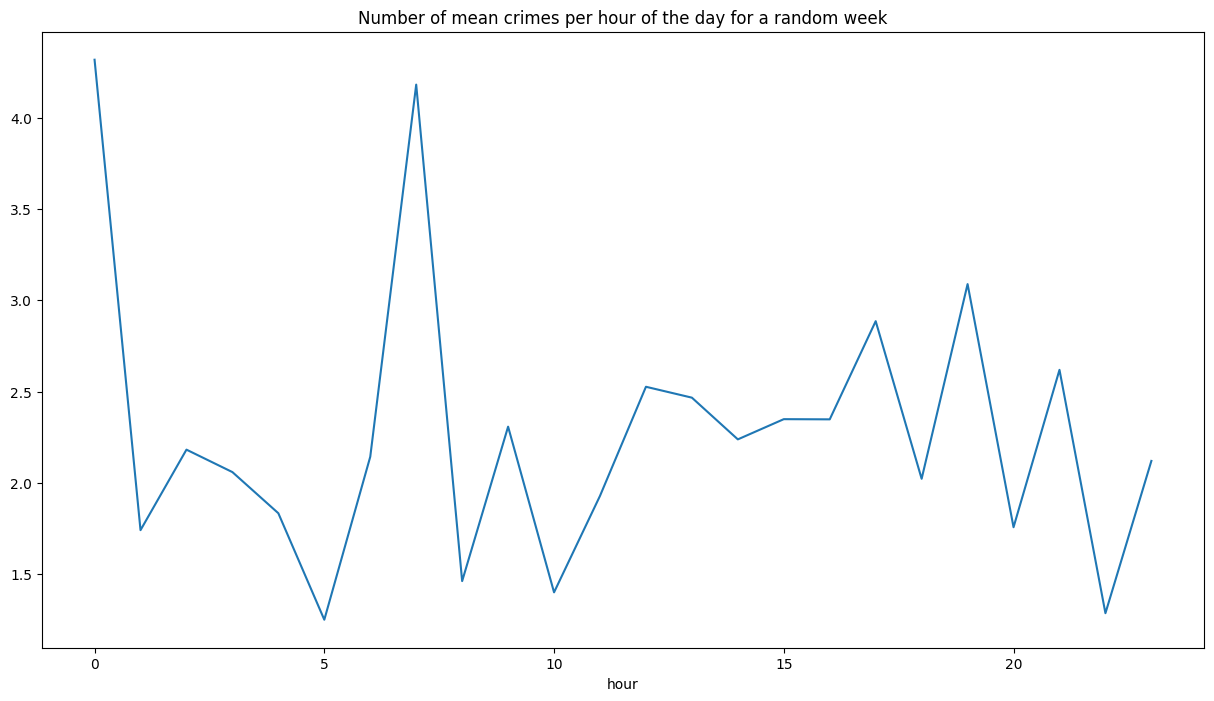

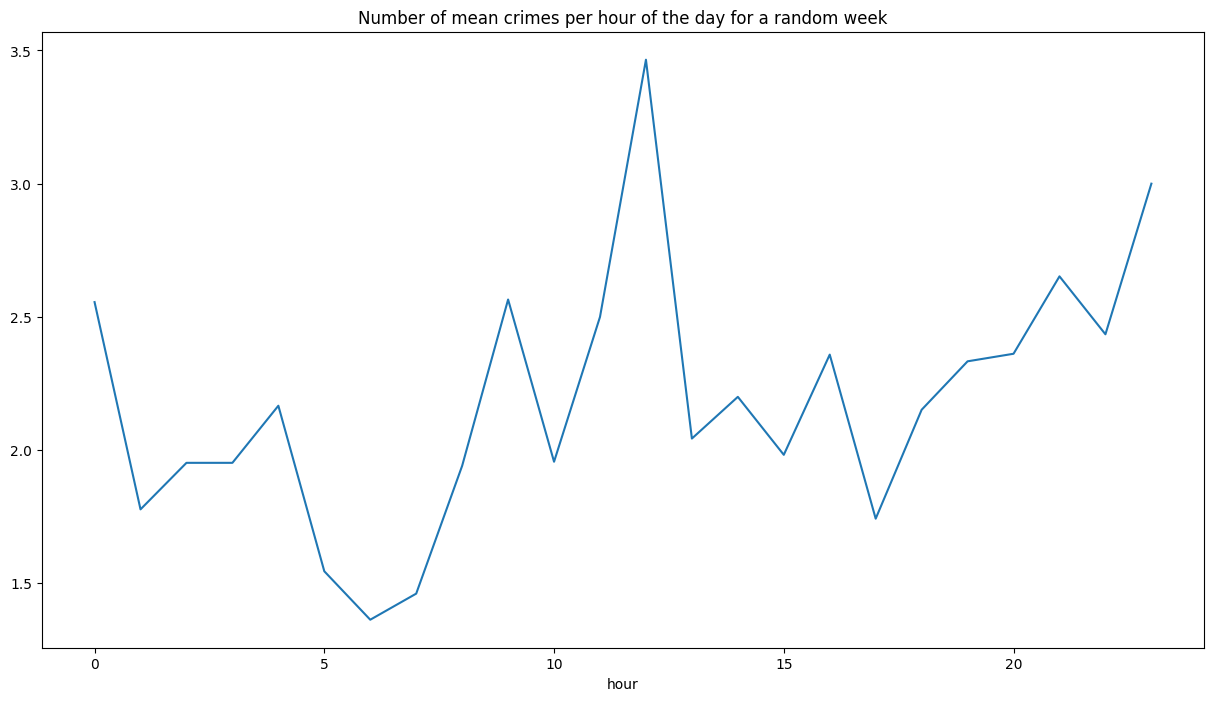

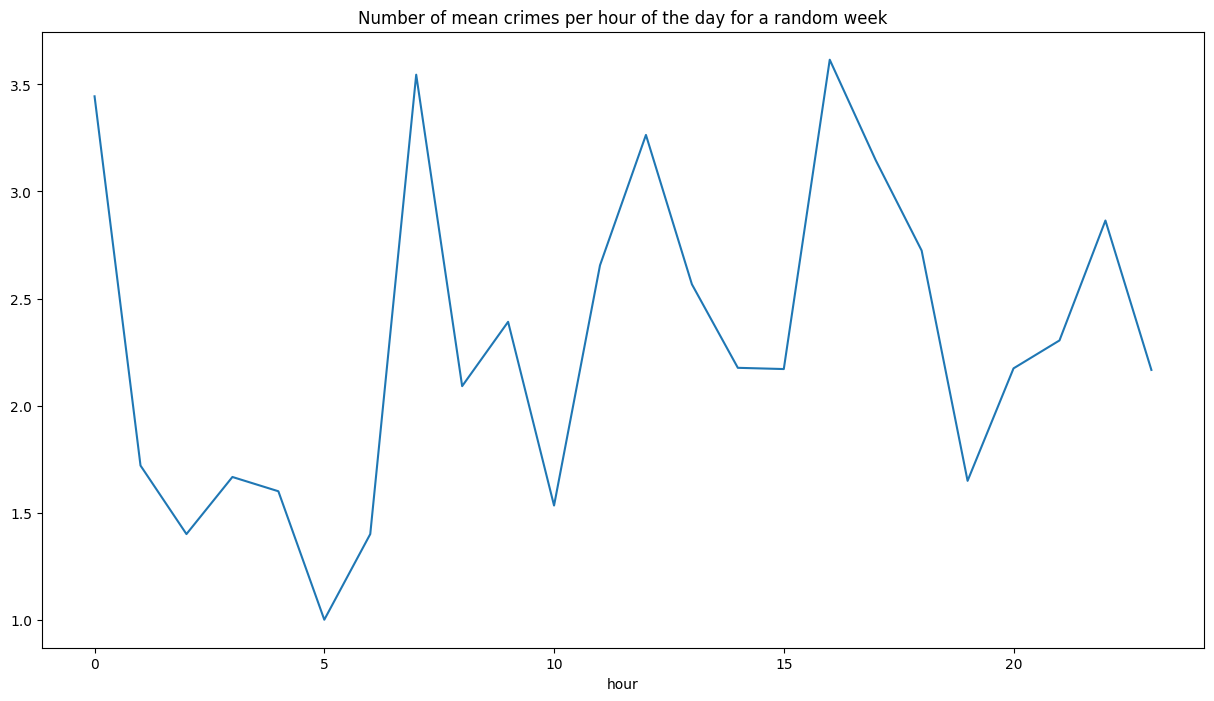

In [95]:
# visualize feature to target relationship
# plot the relationship between hour and num_crimes per hour for a random week
fig, ax = plt.subplots(figsize=(15, 8))
dfXGB['2014-01-01':'2014-01-07'].groupby('hour')['num_crimes_hour'].mean().plot(ax = ax, title = 'Number of mean crimes per hour of the day for a random week')

# a different random week
fig, ax = plt.subplots(figsize=(15, 8))
dfXGB['2014-01-08':'2014-01-14'].groupby('hour')['num_crimes_hour'].mean().plot(ax = ax, title = 'Number of mean crimes per hour of the day for a random week')

# a different random week
fig, ax = plt.subplots(figsize=(15, 8))
dfXGB['2014-01-15':'2014-01-21'].groupby('hour')['num_crimes_hour'].mean().plot(ax = ax, title = 'Number of mean crimes per hour of the day for a random week')


month
1     Axes(0.125,0.2;0.775x0.68)
2     Axes(0.125,0.2;0.775x0.68)
3     Axes(0.125,0.2;0.775x0.68)
4     Axes(0.125,0.2;0.775x0.68)
5     Axes(0.125,0.2;0.775x0.68)
6     Axes(0.125,0.2;0.775x0.68)
7     Axes(0.125,0.2;0.775x0.68)
8     Axes(0.125,0.2;0.775x0.68)
9     Axes(0.125,0.2;0.775x0.68)
10    Axes(0.125,0.2;0.775x0.68)
11    Axes(0.125,0.2;0.775x0.68)
12    Axes(0.125,0.2;0.775x0.68)
Name: num_crimes, dtype: object

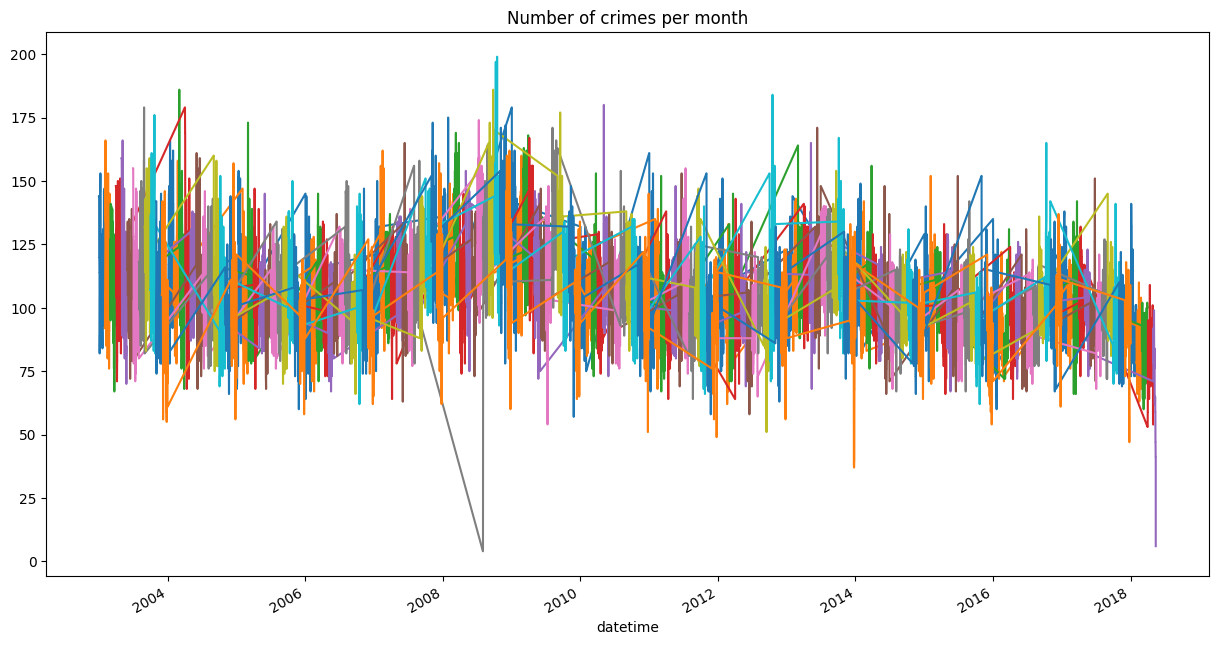

In [96]:
# visualize crimes per month
fig, ax = plt.subplots(figsize=(15, 8))
dfXGB.groupby('month')['num_crimes'].plot(ax = ax, title = 'Number of crimes per month')



<Axes: title={'center': 'mean crimes per month displayed over all 12 months'}, xlabel='month'>

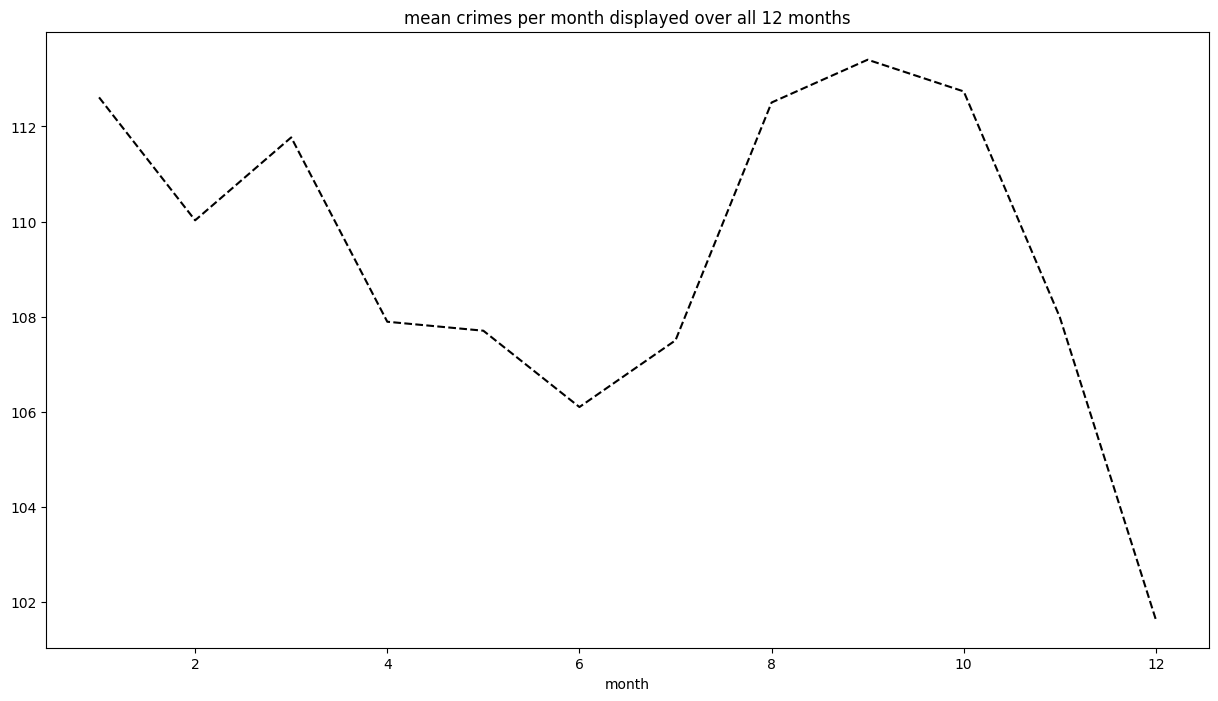

In [97]:
# visualize crimes per month with mean
fig, ax = plt.subplots(figsize=(15, 8))

# add a line for the mean for the specific month
dfXGB.groupby('month')['num_crimes'].mean().plot(ax = ax, title = 'mean crimes per month displayed over all 12 months', color = 'black', linestyle = '--')

<Axes: title={'center': 'Number of crimes per weekday per category'}, xlabel='weekday'>

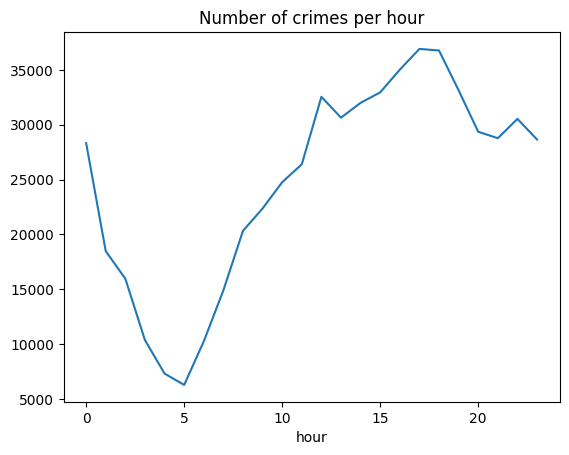

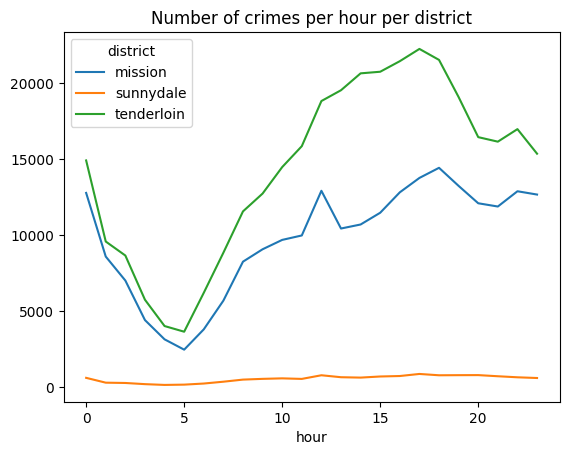

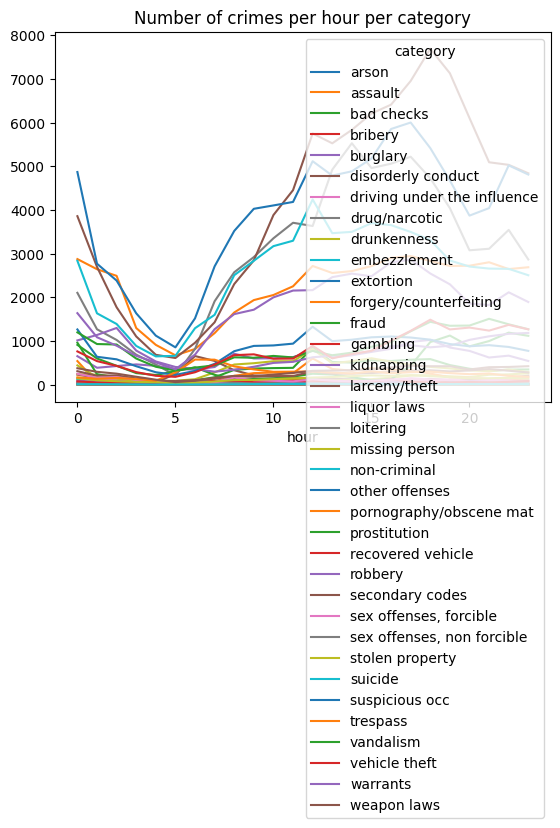

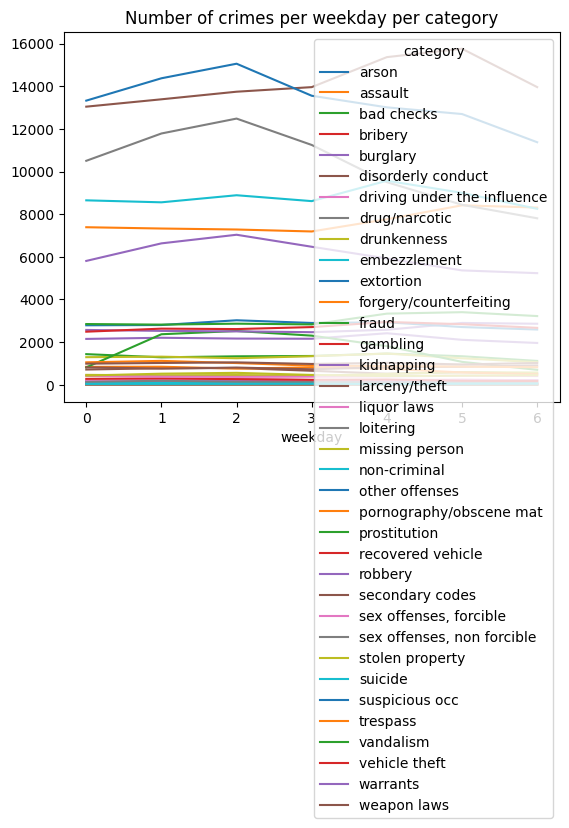

In [98]:
# plot 
df.groupby('hour').size().plot(title='Number of crimes per hour')

# plot number of crimes per hour per district
df.groupby(['hour', 'district']).size().unstack().plot(title='Number of crimes per hour per district')

# plot number of crimes per hour per category
df.groupby(['hour', 'category']).size().unstack().plot(title='Number of crimes per hour per category')  # this is a lot of categories

# plot number of crimes per weekday per category
df.groupby(['weekday', 'category']).size().unstack().plot(title='Number of crimes per weekday per category')  # this is a lot of categories



In [99]:
FEATURES = ['year', 'month', 'day', 'hour', 'minute', 'weekday']
TARGET = 'num_crimes'

In [100]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [23]:
regressor = xgb.XGBRegressor(n_estimators=100, early_stopping_rounds=50)


In [24]:
regressor.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=10)



[0]	validation_0-rmse:19.08763	validation_1-rmse:18.82328
[10]	validation_0-rmse:15.72852	validation_1-rmse:17.11797
[20]	validation_0-rmse:14.55939	validation_1-rmse:17.28482
[30]	validation_0-rmse:13.79223	validation_1-rmse:17.49108
[40]	validation_0-rmse:13.02964	validation_1-rmse:17.64207
[50]	validation_0-rmse:12.35109	validation_1-rmse:17.87603
[54]	validation_0-rmse:12.07416	validation_1-rmse:17.96618


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
# make predictions
y_pred = regressor.predict(X_test)

# print predictions
print(y_pred)

# make a forecast for the dates 2018-05-16 to 2018-05-31
# make a dataframe with the dates
dates = pd.date_range(start='2018-05-16', end='2018-10-31', freq='D')
print(dates)

# make a dataframe with the dates
df_forecast = pd.DataFrame(dates, columns=['datetime'])

# make a dataframe with the features
df_forecast['year'] = df_forecast['datetime'].dt.year
df_forecast['month'] = df_forecast['datetime'].dt.month
df_forecast['day'] = df_forecast['datetime'].dt.day
df_forecast['hour'] = df_forecast['datetime'].dt.hour
df_forecast['minute'] = df_forecast['datetime'].dt.minute
df_forecast['weekday'] = df_forecast['datetime'].dt.weekday

# make a forecast
y_forecast = regressor.predict(df_forecast[['year', 'month', 'day', 'hour', 'minute', 'weekday']])
print(y_forecast)

# make a dataframe with the forecast
df_forecast['num_crimes'] = y_forecast
print(df_forecast)


[111.38584  104.89637  104.89637  ... 104.01831  103.8372    98.499405]
DatetimeIndex(['2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19',
               '2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23',
               '2018-05-24', '2018-05-25',
               ...
               '2018-10-22', '2018-10-23', '2018-10-24', '2018-10-25',
               '2018-10-26', '2018-10-27', '2018-10-28', '2018-10-29',
               '2018-10-30', '2018-10-31'],
              dtype='datetime64[ns]', length=169, freq='D')
[104.89637  104.89637  104.89637  104.89637   98.16281  101.20454
 103.618744 104.89637  104.89637  104.89637  104.89637  112.8318
 101.20454  103.618744 103.65572  103.65572  110.25402  107.05292
  96.5886   101.20454  104.73968  104.01831  104.01831  104.01831
 104.89637   98.16281  101.20454  103.618744 104.89637  104.89637
 104.89637  104.89637   98.16281  101.20454  103.618744 104.89637
 104.89637  104.89637  104.89637  112.8318   101.20454  103.618744
 104.89637  104.

In [ ]:
# set index to datetime
dfXGB = dfXGB.set_index('datetime')  # works only if not done already

/var/folders/_c/3l9yllq94xz0c2hc259xh3jc0000gn/T/ipykernel_56902/3947680241.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dfXGB['2016-12-16':'2018-08-15']['num_crimes'].plot(ax = ax, title = 'Number of crimes per day for the two months before the forecast')


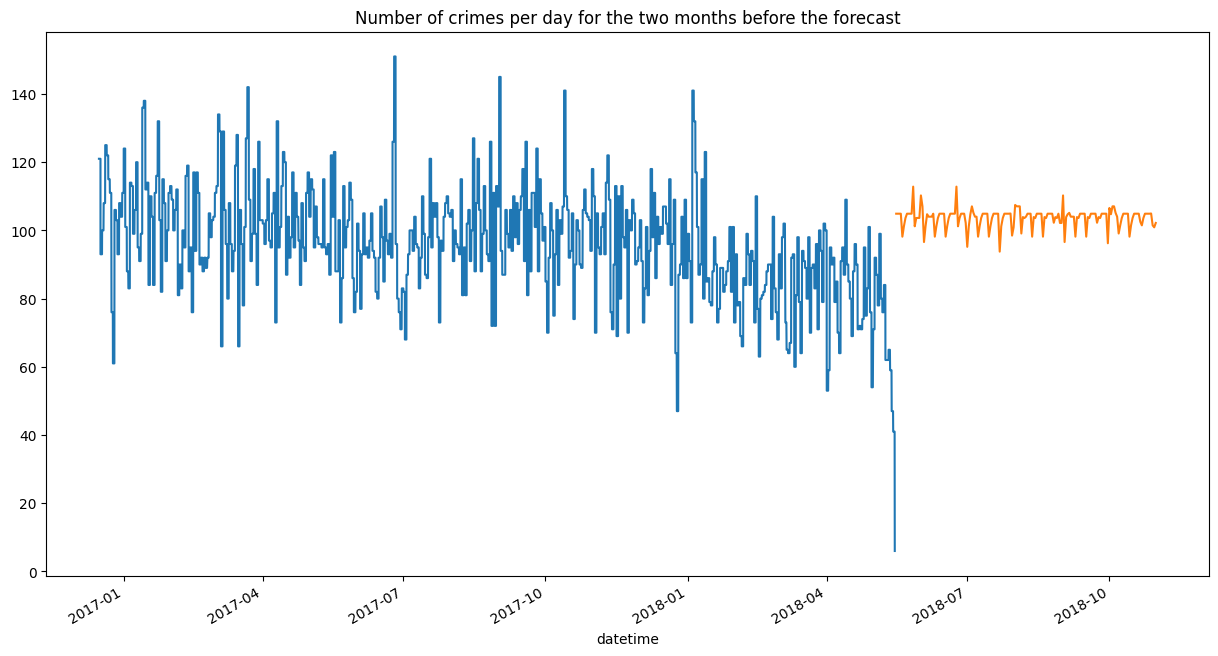

In [27]:
# plot the forecast and the 5 months before
fig, ax = plt.subplots(figsize=(15, 8))
# the two months before '2018-03-16':'2018-05-15'
dfXGB['2016-12-16':'2018-08-15']['num_crimes'].plot(ax = ax, title = 'Number of crimes per day for the two months before the forecast')

# the forecast
df_forecast.set_index('datetime')['num_crimes'].plot(ax = ax, title = 'Number of crimes per day for the two months before the forecast')


plt.show()


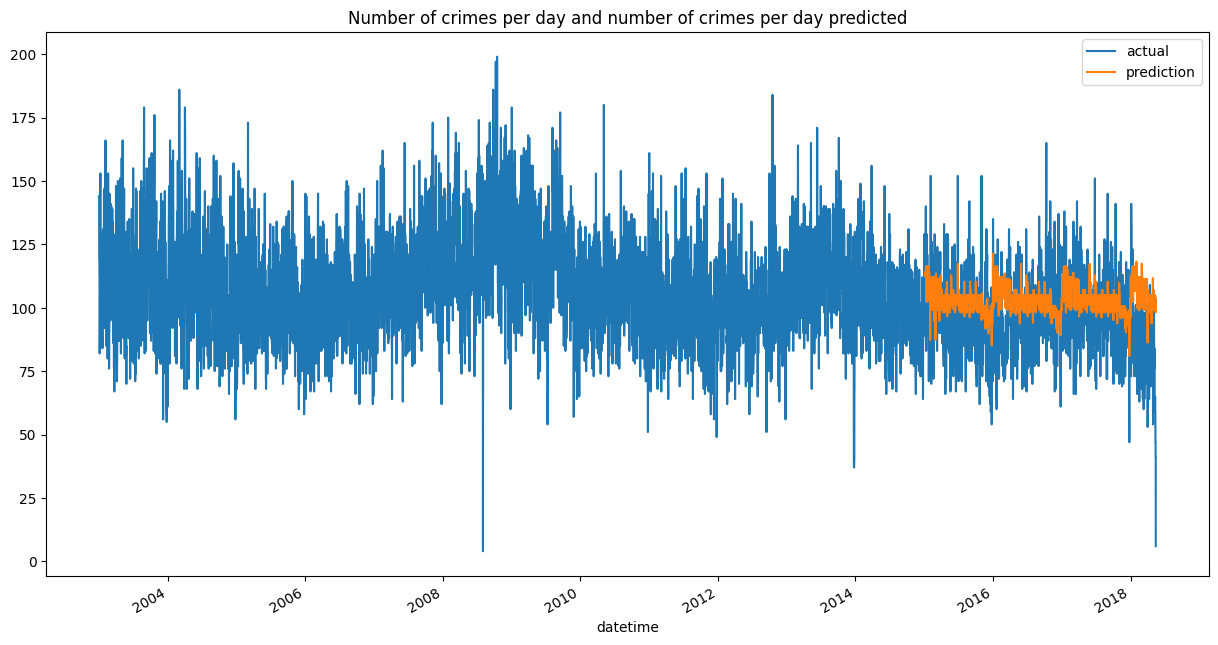

In [28]:
# make a column with the predictions
test['prediction'] = y_pred = regressor.predict(X_test)

# merge the predictions with the test set
dfXGB = dfXGB.merge(test[['prediction']], how = 'left', left_index=True, right_index=True)

# plot number of crimes per day
fig, ax = plt.subplots(figsize=(15, 8))
dfXGB['num_crimes'].plot(ax = ax, title = 'Number of crimes per day')

# plot the predictions
dfXGB['prediction'].plot(ax = ax, title = 'Number of crimes per day')

plt.legend(['actual', 'prediction'])

# title
plt.title('Number of crimes per day and number of crimes per day predicted')

plt.show()

this is the mean absolute error: 13.466686741332472
this is the mean squared error: 291.3062708072872


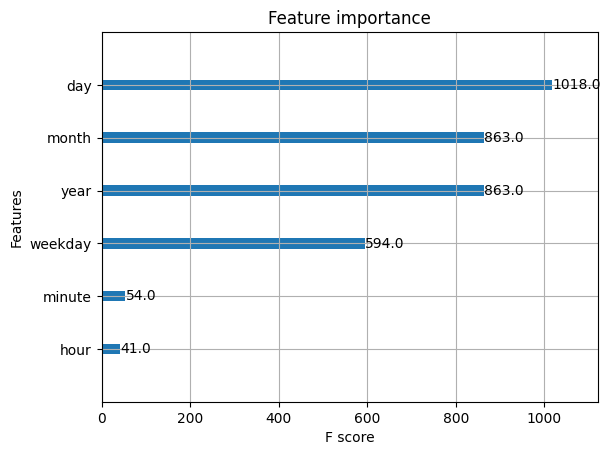

In [29]:
# calculate the mean absolute error
MAE = mean_absolute_error(y_test, y_pred)
print(f'this is the mean absolute error: {MAE}')

# calculate the mean squared error
MSE = mean_squared_error(y_test, y_pred)
print(f'this is the mean squared error: {MSE}')

# plot the feature importances
xgb.plot_importance(regressor)
plt.show()

Now include categorical features. Use one-hot encodings only for low cardinality and prefereably for linear models. Use entity embeddings in this case.

In [104]:
# make a df for categorical model where num_crimes_hour is removed
df_cat = df.drop('num_crimes_hour', axis=1)

# remove prediction, id, longitude, and latitude columns if they exist
df_cat = df_cat.drop(['prediction', 'id', 'longitude', 'latitude'], axis=1, errors='ignore')

# categorical features df
categorical_features = df_cat.select_dtypes(include='category').columns

# remove description as there are too many unique values
categorical_features = categorical_features.drop('description')


# Convert non-numeric categorical features to integers
df_cat[categorical_features] = df_cat[categorical_features].astype('category')
df_cat[categorical_features] = df_cat[categorical_features].apply(lambda x: x.cat.codes)

num_features = df_cat.select_dtypes(include='number').columns
# drop these if they exist
num_features = num_features.drop(['num_crimes', 'category', 'resolution', 'label', 'district'])

print(categorical_features)
print(num_features)

Index(['category', 'resolution', 'label', 'district'], dtype='object')
Index(['weekday', 'year', 'month', 'day', 'hour', 'minute'], dtype='object')


In [114]:
# remove resolution and write to csv and save in the Data folder
#df_cat = df_cat.drop('resolution', axis=1)
#df_cat.to_csv('/Users/kristian/Documents/CasePFA/Models/Data/dfCatandNum.csv')

# make a df with only the categorical features and the target 'category', 'district', 'label', 'resolution' and 'num_crimes'
#df_cat = df[['category', 'district', 'label', 'resolution', 'num_crimes', 'datetime']]

# write df_cat to csv and save in the Data folder
df_cat.to_csv('/Users/kristian/Documents/CasePFA/Models/Data/dfCategorical.csv')



In [112]:
df

,id,category,description,weekday,date,time,resolution,longitude,latitude,label,district,datetime,year,month,day,hour,minute,num_crimes,num_crimes_hour
0,18023216504170,assault,false imprisonment,5,2018-03-24,07:00:00,none,-122.419053,37.758632,violent,mission,2018-03-24 07:00:00,2018,3,24,7,0,83,3
1,17067335371000,non-criminal,lost property,2,2017-07-19,12:00:00,none,-122.419672,37.765050,other,mission,2017-07-19 12:00:00,2017,7,19,12,0,95,4
2,17083623864020,non-criminal,"aided case, mental disturbed",4,2017-10-13,06:45:00,none,-122.416894,37.784286,other,tenderloin,2017-10-13 06:45:00,2017,10,13,6,45,141,2
3,18029886606243,larceny/theft,petty theft from locked auto,6,2018-04-22,18:00:00,none,-122.420691,37.781483,other,tenderloin,2018-04-22 18:00:00,2018,4,22,18,0,72,1
4,16624968706372,larceny/theft,petty theft of property,6,2016-08-21,10:00:00,none,-122.417885,37.785438,other,tenderloin,2016-08-21 10:00:00,2016,8,21,10,0,104,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592849,17611106006244,larceny/theft,grand theft from locked auto,2,2017-04-26,18:00:00,none,-122.407933,37.781506,other,tenderloin,2017-04-26 18:00:00,2017,4,26,18,0,108,2
592850,16105518806244,larceny/theft,grand theft from locked auto,2,2016-12-28,22:34:00,none,-122.416642,37.787245,other,tenderloin,2016-12-28 22:34:00,2016,12,28,22,34,93,1
592851,17055331319057,assault,threats against life,5,2017-07-08,03:30:00,none,-122.407745,37.752934,violent,mission,2017-07-08 03:30:00,2017,7,8,3,30,104,3
592852,17000428151041,non-criminal,aided case -property for destruction,5,2016-12-31,18:00:00,none,-122.406521,37.785063,other,tenderloin,2016-12-31 18:00:00,2016,12,31,18,0,111,3


In [61]:
# an embedding model using pytorch
class EmbeddingModel(nn.Module):
    def __init__(self, embd_sizes, num_numerical_features):
        super(EmbeddingModel, self).__init__()
        self.embd_layers = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embd_sizes])
        self.num_layers = num_numerical_features

    def forward(self, x_cat, x_num):
        print(x_cat.shape)
        embd_outputs = [embdedding(x_cat[:,i]) for i, embdedding in enumerate(self.embd_layers)]  
        embd_outputs = torch.cat(embd_outputs, axis = 1)
        concatenated_outputs = torch.cat((embd_outputs, x_num), axis = 1)
        return concatenated_outputs
        

In [62]:
categorical_features = ['category', 'resolution', 'label', 'district']
numerical_features = ['year', 'month', 'day', 'hour', 'minute', 'weekday']


In [63]:
# define the sizes of embeddings for each categorical feature
embd_sizes = [(categories, size) for categories, size in zip(df_cat[categorical_features].nunique(), [1]*len(categorical_features))]


In [64]:
# instantiate the model
model = EmbeddingModel(embd_sizes, len(numerical_features))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [65]:
# convert to tensor
categorical_inputs = torch.tensor(df_cat[categorical_features].values, dtype = torch.long)
numerical_inputs = torch.tensor(df_cat[numerical_features].values, dtype = torch.float32)
targets = torch.tensor(df_cat['num_crimes'].values, dtype = torch.float32)

In [66]:

# make targets and outputs the same shape
targets = targets.view(-1, 1) # this is extremely suspicious and should be checked
print(targets.shape)



torch.Size([592854, 1])


In [67]:
# train model
for epoch in range(100):
    optimizer.zero_grad()
    output = model(categorical_inputs, numerical_inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()
    print(f'this is the loss: {loss}')

torch.Size([592854, 4])
this is the loss: 371242.125
torch.Size([592854, 4])


/Users/kristian/.local/share/virtualenvs/DataViz-TTGQRQcT/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([592854, 1])) that is different to the input size (torch.Size([592854, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


this is the loss: 371241.25
torch.Size([592854, 4])
this is the loss: 371240.34375
torch.Size([592854, 4])
this is the loss: 371239.46875
torch.Size([592854, 4])
this is the loss: 371238.59375
torch.Size([592854, 4])
this is the loss: 371237.71875
torch.Size([592854, 4])
this is the loss: 371236.8125
torch.Size([592854, 4])
this is the loss: 371235.96875
torch.Size([592854, 4])
this is the loss: 371235.09375
torch.Size([592854, 4])
this is the loss: 371234.21875
torch.Size([592854, 4])
this is the loss: 371233.375
torch.Size([592854, 4])
this is the loss: 371232.5
torch.Size([592854, 4])
this is the loss: 371231.59375
torch.Size([592854, 4])
this is the loss: 371230.71875
torch.Size([592854, 4])
this is the loss: 371229.84375
torch.Size([592854, 4])
this is the loss: 371228.9375
torch.Size([592854, 4])
this is the loss: 371228.0625
torch.Size([592854, 4])
this is the loss: 371227.1875
torch.Size([592854, 4])
this is the loss: 371226.3125
torch.Size([592854, 4])
this is the loss: 371225

In [68]:
# Extract embeddings from the trained model
embeddings = [embedding.weight.detach().numpy() for embedding in model.embd_layers]



# Concatenate embeddings with numerical features pad the embeddings to have dimensions of the same size

# pad all embeddings to get the size (36, 10)
max_length = max([embedding.shape[0] for embedding in embeddings])
for i, embedding in enumerate(embeddings):
    pad_length = max_length - embedding.shape[0]
    embeddings[i] = np.pad(embedding, ((0, pad_length), (0, 0)), 'constant', constant_values=0)



# concatenate the embeddings
X = np.concatenate(embeddings, axis=1)


In [69]:
# get weight embeddings
for col in categorical_features:
    weight_embeddings = col + '_embedding'
    weight_df = pd.DataFrame(model.embd_layers[i].weight.detach().numpy(), columns = [col + '_embedding' + str(i) for i in range(1)])


# create a dictionary that maps each embedding value to the original categorical level
embedding_dict = {}
for i, col in enumerate(categorical_features):
    weight_embeddings = col + '_embedding'
    weight_df = pd.DataFrame(model.embd_layers[i].weight.detach().numpy(), columns = [col + '_embedding' + str(i) for i in range(1)])
    embedding_dict[col] = weight_df.idxmax(axis=1).to_dict()



# make a dataframe with the embeddings
df_embed = pd.DataFrame(X, columns = [col + '_embedding' + str(i) for i in range(1) for col in categorical_features])



In [70]:
# assign the embeddings to the original categorical levels
for col in categorical_features:
    for i in col:
        # the first embedding should be assigned to the first unique value of the categorical feature
        df_embed[col + '_embedding' + str(i)] = df_cat[col].map(embedding_dict[col])


        

In [71]:
def map_embeddings_to_categories(df_embed, df_cat):
    # category
    cat_embed = df_embed['category_embedding0']
    unique_cat = df_cat['category'].unique()
    embedding_map_cat = {category: embedding for category, embedding in zip(unique_cat, cat_embed)}
    df_cat['category'] = df_cat['category'].map(embedding_map_cat)

    # resolution
    res_embed = df_embed['resolution_embedding0']
    unique_res = df_cat['resolution'].unique()
    embedding_map_res = {resolution: embedding for resolution, embedding in zip(unique_res, res_embed)}
    df_cat['resolution'] = df_cat['resolution'].map(embedding_map_res)

    # label
    lab_embed = df_embed['label_embedding0']
    unique_lab = df_cat['label'].unique()
    embedding_map_lab = {label: embedding for label, embedding in zip(unique_lab, lab_embed)}
    df_cat['label'] = df_cat['label'].map(embedding_map_lab)

    # district
    dist_embed = df_embed['district_embedding0']
    unique_dist = df_cat['district'].unique()
    embedding_map_dist = {district: embedding for district, embedding in zip(unique_dist, dist_embed)}
    df_cat['district'] = df_cat['district'].map(embedding_map_dist)

    return df_cat

# use function to map embeddings to categories
df_cat = map_embeddings_to_categories(df_embed, df_cat)



In [72]:
# make train and test by finding the 80th percentile
train = df_cat[df_cat['datetime'] < df_cat['datetime'].quantile(0.8)]
test = df_cat[df_cat['datetime'] >= df_cat['datetime'].quantile(0.8)]

# set datetime as index
train = train.set_index('datetime')
test = test.set_index('datetime')

In [73]:
# define features and target
FEATURES = ['year', 'month', 'day', 'hour', 'minute', 'weekday', 'category', 'resolution', 'label', 'district']  # order is important
TARGET = 'num_crimes'

# make x and y
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [74]:
# define cat regressor
cat_regressor = xgb.XGBRegressor(n_estimators=100, early_stopping_rounds=50)

# fit the model
cat_regressor.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=10)


[0]	validation_0-rmse:19.08763	validation_1-rmse:18.82328
[10]	validation_0-rmse:15.92797	validation_1-rmse:17.03664
[20]	validation_0-rmse:14.66199	validation_1-rmse:17.27315
[30]	validation_0-rmse:13.67574	validation_1-rmse:17.38202
[40]	validation_0-rmse:13.11066	validation_1-rmse:17.64958
[50]	validation_0-rmse:12.59014	validation_1-rmse:18.67799
[60]	validation_0-rmse:12.18585	validation_1-rmse:19.51303
[63]	validation_0-rmse:12.05226	validation_1-rmse:19.61346


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [75]:
# make predictions
y_pred_cat = cat_regressor.predict(X_test)

# print predictions
print(y_pred_cat)

# make a forecast for the dates 2018-05-16 to 2018-05-31
# make a dataframe with the dates
dates_cat = pd.date_range(start='2018-05-16', end='2018-10-31', freq='D')
print(dates_cat)

# make a dataframe with the dates
df_forecast_cat = pd.DataFrame(dates_cat, columns=['datetime'])

# make a dataframe with the features
df_forecast_cat['year'] = df_forecast_cat['datetime'].dt.year
df_forecast_cat['month'] = df_forecast_cat['datetime'].dt.month
df_forecast_cat['day'] = df_forecast_cat['datetime'].dt.day
df_forecast_cat['hour'] = df_forecast_cat['datetime'].dt.hour
df_forecast_cat['minute'] = df_forecast_cat['datetime'].dt.minute
df_forecast_cat['weekday'] = df_forecast_cat['datetime'].dt.weekday
df_forecast_cat['category'] = df_cat['category']
df_forecast_cat['resolution'] = df_cat['resolution']
df_forecast_cat['label'] = df_cat['label']
df_forecast_cat['district'] = df_cat['district']

print(df_forecast_cat)

# make a forecast
y_forecast_cat = cat_regressor.predict(df_forecast_cat[['year', 'month', 'day', 'hour', 'minute', 'weekday', 'category', 'resolution', 'label', 'district']])
print(y_forecast_cat)

# make a dataframe with the forecast
df_forecast_cat['num_crimes'] = y_forecast_cat
print(df_forecast_cat)

[110.97564 101.60913 104.85244 ... 103.53496 103.628    93.47579]
DatetimeIndex(['2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19',
               '2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23',
               '2018-05-24', '2018-05-25',
               ...
               '2018-10-22', '2018-10-23', '2018-10-24', '2018-10-25',
               '2018-10-26', '2018-10-27', '2018-10-28', '2018-10-29',
               '2018-10-30', '2018-10-31'],
              dtype='datetime64[ns]', length=169, freq='D')
      datetime  year  month  day  hour  minute  weekday  category  resolution  \
0   2018-05-16  2018      5   16     0       0        2  1.893655    0.550361   
1   2018-05-17  2018      5   17     0       0        3  0.070865    0.550361   
2   2018-05-18  2018      5   18     0       0        4  0.070865    0.550361   
3   2018-05-19  2018      5   19     0       0        5  0.663533    0.550361   
4   2018-05-20  2018      5   20     0       0        6  0.663533    0.550361  

In [76]:
# set index on datetime on all the dataframes you want to plot
df_cat = df_cat.set_index('datetime')

/var/folders/_c/3l9yllq94xz0c2hc259xh3jc0000gn/T/ipykernel_56902/1897951125.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_cat['2016-12-16':'2018-08-15']['num_crimes'].plot(ax = ax, title = 'Number of crimes per day for the two months before the forecast')


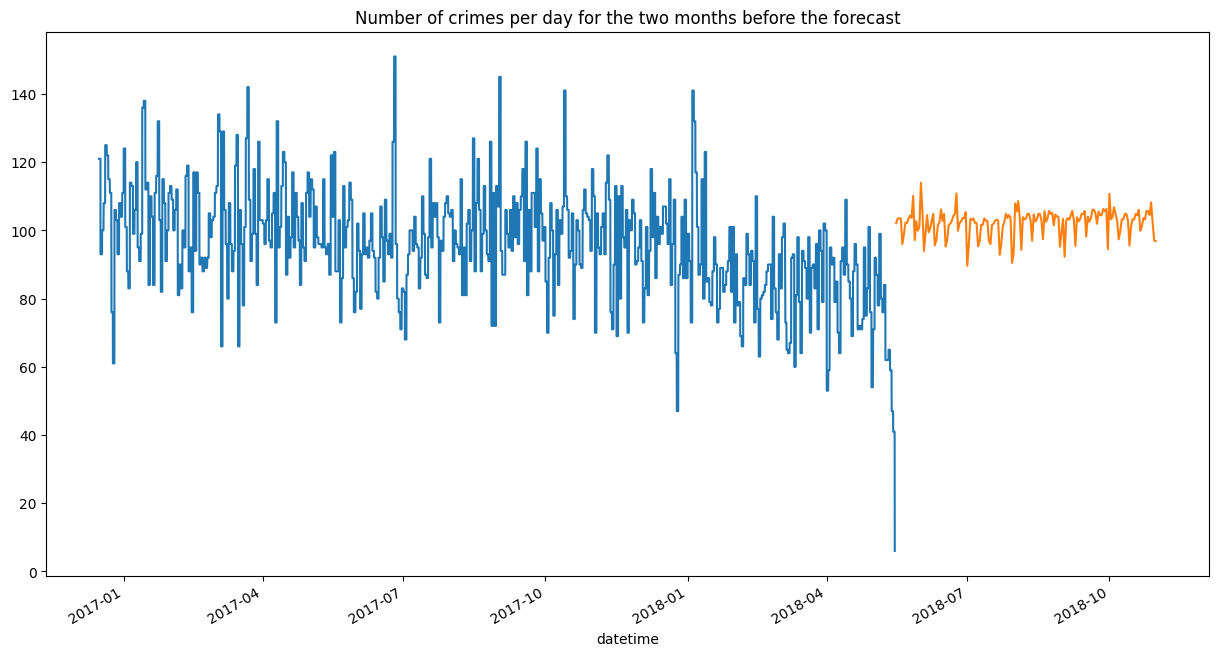

In [77]:
# plot the forecast and the 5 months before
fig, ax = plt.subplots(figsize=(15, 8))
# the two months before '2018-03-16':'2018-05-15'
df_cat['2016-12-16':'2018-08-15']['num_crimes'].plot(ax = ax, title = 'Number of crimes per day for the two months before the forecast')

# the forecast
df_forecast_cat.set_index('datetime')['num_crimes'].plot(ax = ax, title = 'Number of crimes per day for the two months before the forecast')


plt.show()

                     category                  description  weekday  \
datetime                                                              
2003-01-01 00:01:00  0.663533  petty theft from a building        2   
2003-01-01 00:01:00  1.372695                      begging        2   
2003-01-01 00:01:00  1.893655         threats against life        2   
2003-01-01 00:01:00  0.070865               found property        2   
2003-01-01 00:01:00  0.929248        suspicious occurrence        2   
...                       ...                          ...      ...   
2018-05-15 02:01:00  2.647319     traffic violation arrest        1   
2018-05-15 02:01:00  2.647319     traffic violation arrest        1   
2018-05-15 02:01:00  2.647319     traffic violation arrest        1   
2018-05-15 02:01:00  2.647319     traffic violation arrest        1   
2018-05-15 02:01:00  2.647319     traffic violation arrest        1   

                           date      time  resolution     label  district  \

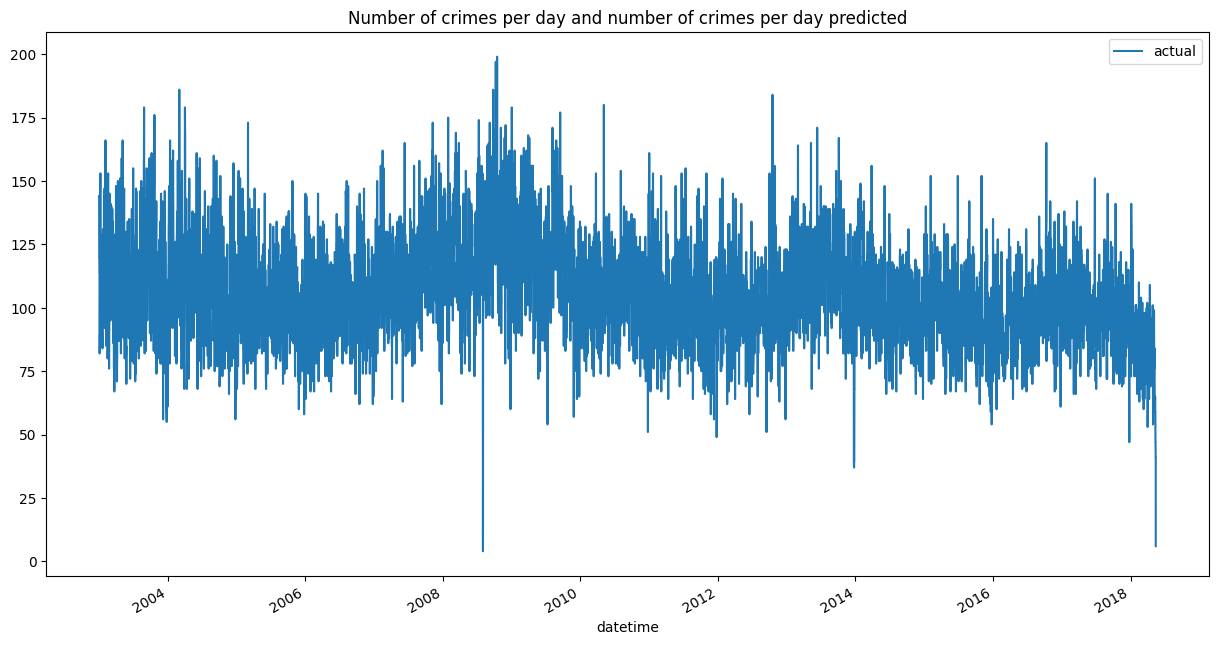

In [80]:
# make a column with the predictions
test['prediction'] = y_pred_cat

# merge the predictions with the test set
df_cat = df_cat.merge(test[['prediction']], how = 'left', left_index=True, right_index=True)
print(df_cat)

# plot number of crimes per day
fig, ax = plt.subplots(figsize=(15, 8))
df_cat['num_crimes'].plot(ax = ax, title = 'Number of crimes per day')

# plot the predictions
#df_cat['prediction'].plot(ax = ax, title = 'Number of crimes per day')

plt.legend(['actual', 'prediction'])

# title
plt.title('Number of crimes per day and number of crimes per day predicted')

plt.show()

[0]	validation_0-rmse:20.62970	validation_1-rmse:20.15343
[10]	validation_0-rmse:20.52588	validation_1-rmse:19.81416
[20]	validation_0-rmse:20.52049	validation_1-rmse:19.79781
[30]	validation_0-rmse:20.51759	validation_1-rmse:19.79787
[40]	validation_0-rmse:20.51592	validation_1-rmse:19.79841
[50]	validation_0-rmse:20.51438	validation_1-rmse:19.79879
[60]	validation_0-rmse:20.51363	validation_1-rmse:19.80036
[70]	validation_0-rmse:20.51295	validation_1-rmse:19.79989
[75]	validation_0-rmse:20.51257	validation_1-rmse:19.80058
[110.1506   109.75904  109.46111  ... 110.1506   109.46111  115.832565]
DatetimeIndex(['2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19',
               '2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23',
               '2018-05-24', '2018-05-25',
               ...
               '2018-10-22', '2018-10-23', '2018-10-24', '2018-10-25',
               '2018-10-26', '2018-10-27', '2018-10-28', '2018-10-29',
               '2018-10-30', '2018-10-31'],
        

/var/folders/_c/3l9yllq94xz0c2hc259xh3jc0000gn/T/ipykernel_56902/2431858470.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_cat['2016-12-16':'2018-08-15']['num_crimes'].plot(ax = ax, title = 'Number of crimes per day for the two months before the forecast')


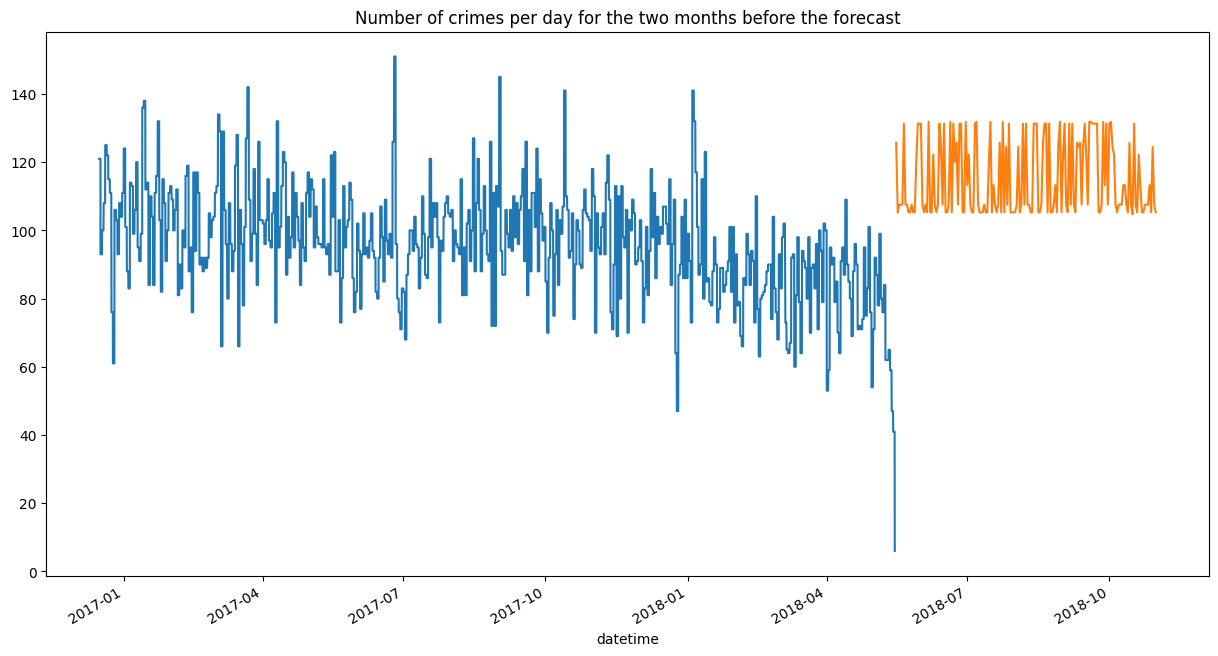

In [56]:
# a model using only the categorical features
CAT_FEATURES = ['category', 'resolution', 'label', 'district']
CAT_TARGET = 'num_crimes'

X_train_cat = train[CAT_FEATURES]
y_train_cat = train[CAT_TARGET]

X_test_cat = test[CAT_FEATURES]
y_test_cat = test[CAT_TARGET]

cat_regressor = xgb.XGBRegressor(n_estimators=100, early_stopping_rounds=50)

cat_regressor.fit(X_train_cat, y_train_cat,
                eval_set=[(X_train_cat, y_train_cat), (X_test_cat, y_test_cat)],
                verbose=10)

# make predictions
y_pred_cat = cat_regressor.predict(X_test_cat)

# print predictions
print(y_pred_cat)

# make a forecast for the dates 2018-05-16 to 2018-05-31
# make a dataframe with the dates
dates_cat = pd.date_range(start='2018-05-16', end='2018-10-31', freq='D')
print(dates_cat)

# make a dataframe with the dates
df_forecast_cat_only = pd.DataFrame(dates_cat, columns=['datetime'])

# make a dataframe with the features
df_forecast_cat_only['category'] = df['category']
df_forecast_cat_only['resolution'] = df['resolution']
df_forecast_cat_only['label'] = df['label']
df_forecast_cat_only['district'] = df['district']

print(df_forecast_cat_only)

# make a forecast
y_forecast_cat = cat_regressor.predict(df_forecast_cat_only[['category', 'resolution', 'label', 'district']])
print(y_forecast_cat)

# make a dataframe with the forecast
df_forecast_cat_only['num_crimes'] = y_forecast_cat
print(df_forecast_cat_only)

# set index on datetime on all the dataframes you want to plot
#df_cat = df_cat.set_index('datetime')

# plot the forecast and the 5 months before
fig, ax = plt.subplots(figsize=(15, 8))
# the two months before '2018-03-16':'2018-05-15'
df_cat['2016-12-16':'2018-08-15']['num_crimes'].plot(ax = ax, title = 'Number of crimes per day for the two months before the forecast')

# the forecast
df_forecast_cat_only.set_index('datetime')['num_crimes'].plot(ax = ax, title = 'Number of crimes per day for the two months before the forecast')


plt.show()




